Import the libraries

In [1]:
import sys
import os
import mlflow
import mlflow.sklearn


from pathlib import Path

# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# sys.path.append(str(Path.cwd().parent))

experiment_name = 'CNN_Model_Training_Experiment'

mlflow_dir = "./mlruns"

mlflow_dir = Path(mlflow_dir)

if not os.path.exists(mlflow_dir):
    os.makedirs(mlflow_dir)

mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

mlflow.set_experiment(experiment_name)


mlflow.autolog()
mlflow.sklearn.autolog(log_models=True, log_datasets=True)



/media/niteshkumar/SSD_Store_0_nvme/allPythoncodesWithPipEnv/BitsLearning/MLOps_Assignment/Assignment_2/bitsMtech_MLOps_Assignment_2/.mlopsAssignment2Env/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:184: FutureWarning: The filesystem tracking backend (e.g., './mlruns') is deprecated as of February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://mlflow.org/docs/latest/self-hosting/migrate-from-file-store for migration guidance.
  return FileStore(store_uri, store_uri)


In [2]:
import torch

# Check if a GPU is available
print(torch.cuda.is_available())

# Get the name of the device
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3080 Ti


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

# x = torch.tensor([1.0, 2.0, 3.0]).to(device)

# x = torch.tensor([1.0, 2.0, 3.0]).to(device)

# # Any operation now uses CUDA cores
# y = x * 2
# print(y)
import tensorflow as tf
tf.config.optimizer.set_jit(True) # Enables XLA globally

cuda


2026-02-21 22:59:18.396272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026/02/21 22:59:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2026/02/21 22:59:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


Load packages

In [4]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

%matplotlib inline 

2026/02/21 22:59:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


Parameters

In [5]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 64
NO_EPOCHS = 20
NUM_CLASSES = 2
SAMPLE_SIZE = 20000

IMG_SIZE = 224


# # TRAIN_FOLDER = './train/'
# # TEST_FOLDER =  './test/'

# # PATH = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/'
# RESNET_WEIGHTS_PATH = './resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

## Read the data

In [6]:

# Save datasets path
# train_image_path = "DataFiles/SampleFiles/train/"
# test_image_path = "DataFiles/SampleFiles/test/"

TRAIN_FOLDER = "DataFiles/SampleFiles/train/"
TEST_FOLDER =  "DataFiles/SampleFiles/test/"

# train_image_list = os.listdir(train_image_path)[0:SAMPLE_SIZE]
train_image_list = os.listdir(TRAIN_FOLDER)
test_image_list = os.listdir(TEST_FOLDER)

print(len(train_image_list))
print(len(test_image_list))


82
40


In [7]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

In [8]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df


## Data exploration

### Class Distribution

Train images distribution


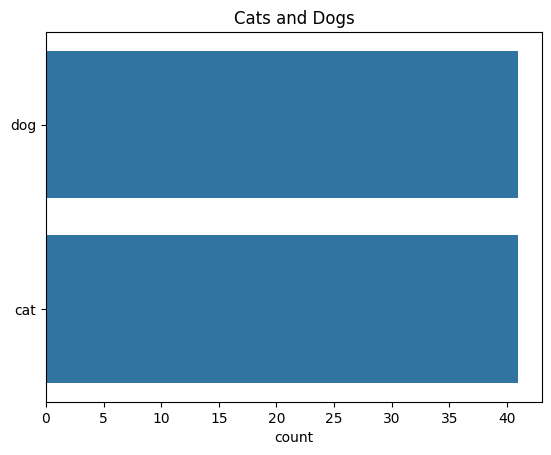

In [9]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    sns.countplot(labels)
    plt.title('Cats and Dogs')


print("Train images distribution")
plot_image_list_count(train_image_list)


In [10]:
train = process_data(train_image_list, TRAIN_FOLDER)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 1302.65it/s]


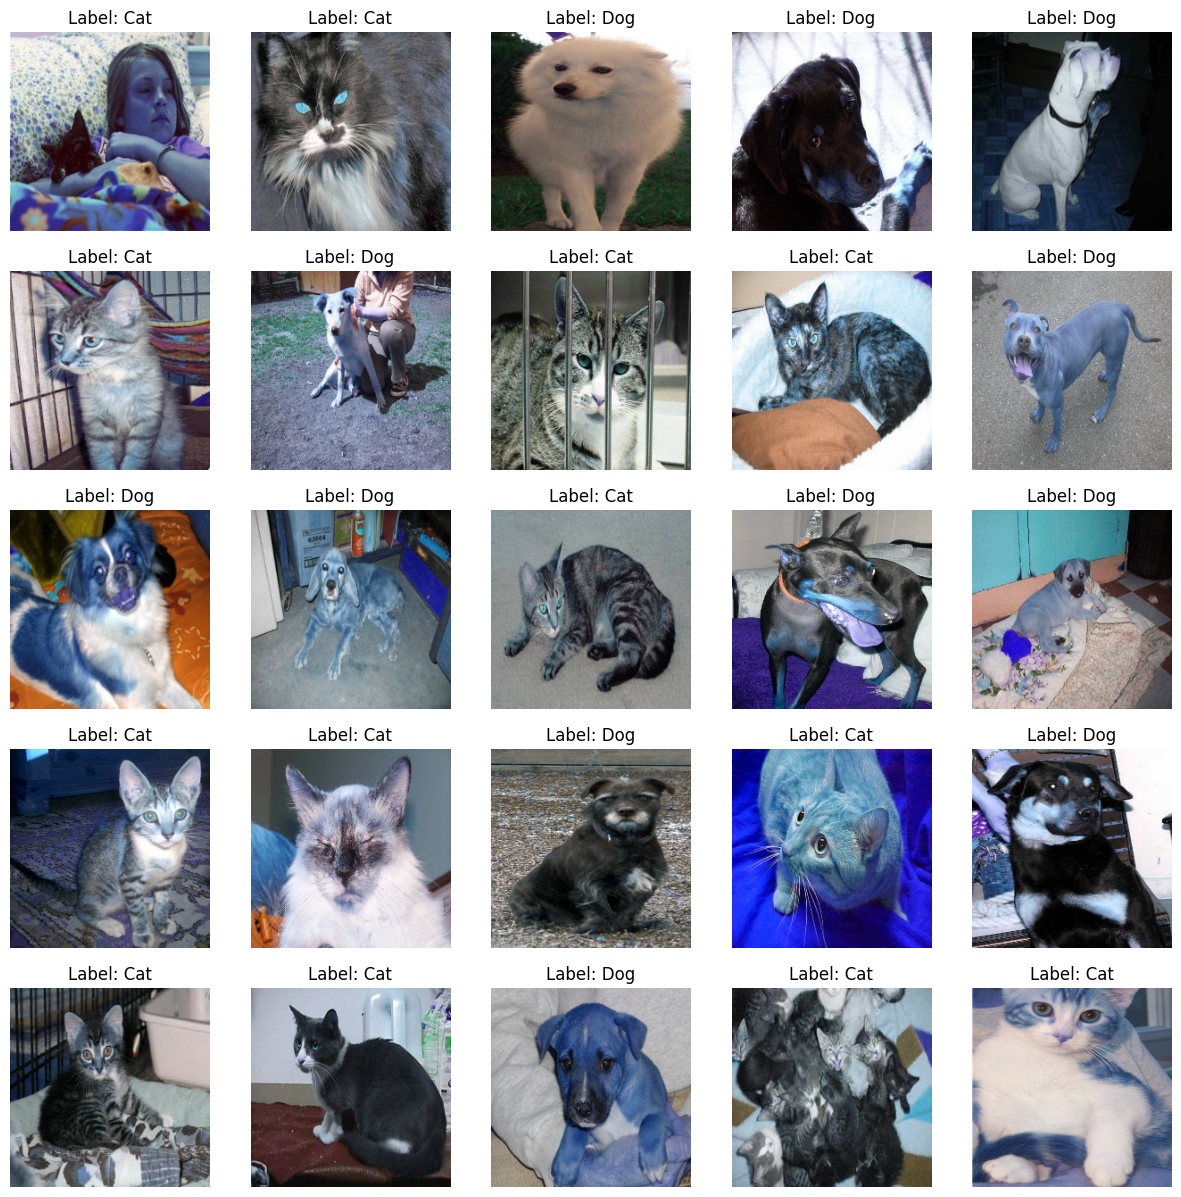

In [11]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(train)

In [12]:
test = process_data(test_image_list, TEST_FOLDER, False)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1611.52it/s]


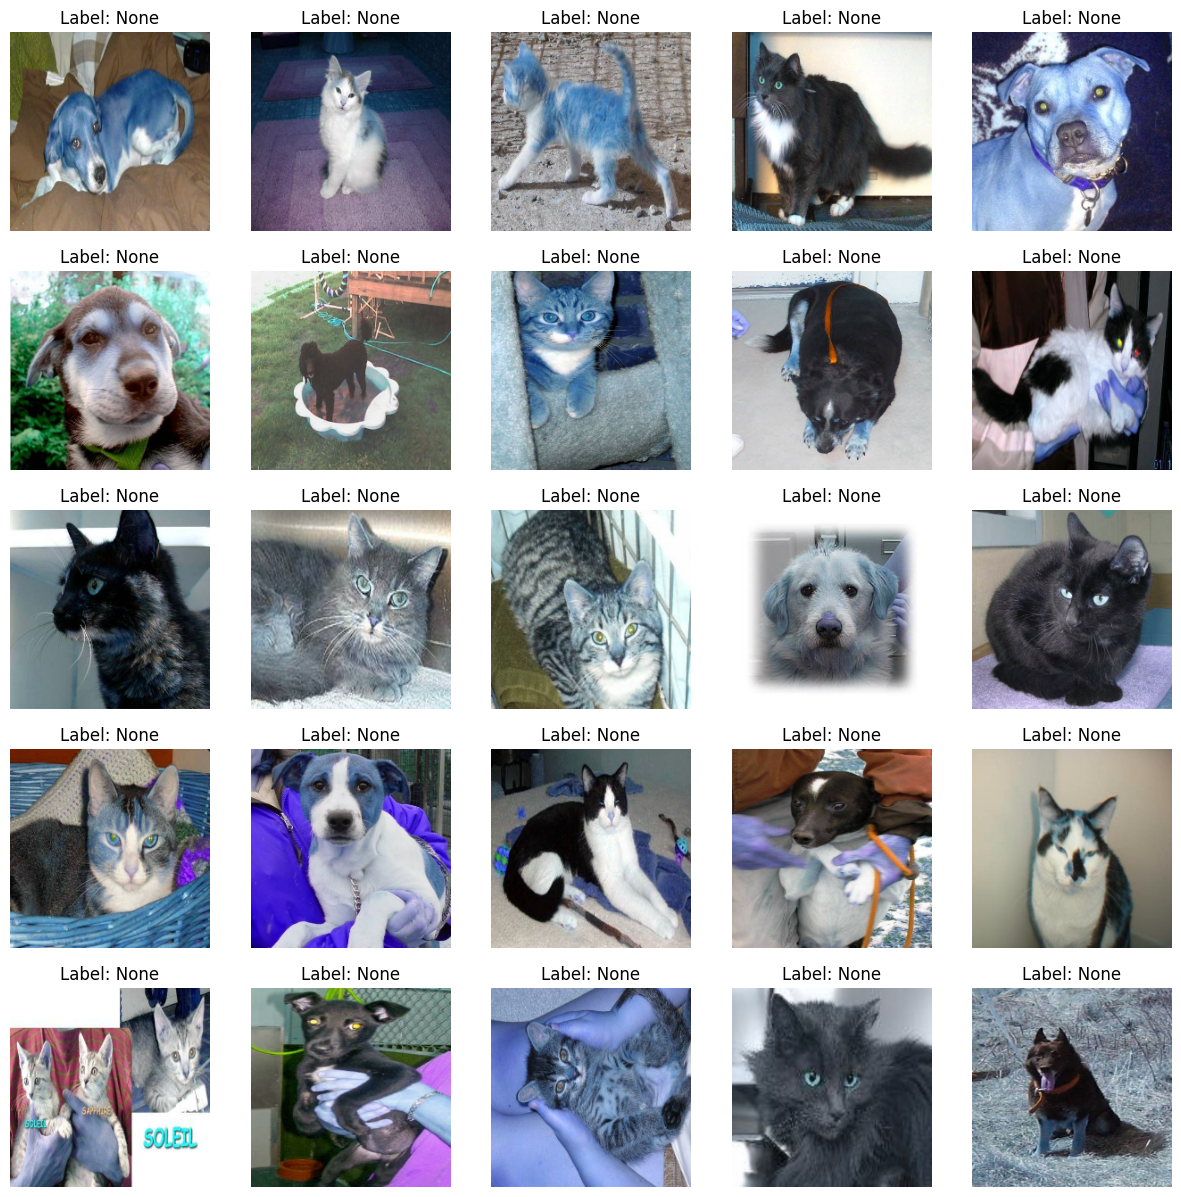

In [13]:
show_images(test,True)


## Model

### Prepare the model

In [14]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [15]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True


I0000 00:00:1771694969.962828    7273 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9560 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6
2026-02-21 22:59:30.233007: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:41] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykernel_launcher.runfiles/cuda_nvdisasm
  ipykernel_launcher.runfiles/nvidia_nvshmem
  ipykern/cuda_nvcc
  ipykern/cuda_nvdisasm
  ipykern/nvidia_nvshmem
  
  /usr/local/cuda
  /opt/cuda
  /media/niteshkumar/SSD_Store_0_nvme/allPythoncodesWithPipEnv/BitsLearning/MLOps_Assignment/Assignment_2/bitsMtech_MLOps_Assignment_2/.mlopsAssignment2Env/lib/python3.12/site-pa

In [16]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

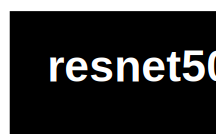

In [18]:
plot_model(model, to_file='model.png')


SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Train the model

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

2026/02/21 22:59:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ce519bf7264b44ac9f9b6dba918efef6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/20


2026-02-21 22:59:46.253560: I external/local_xla/xla/service/service.cc:163] XLA service 0x72bcd8088000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-21 22:59:46.253574: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2026-02-21 22:59:46.537100: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-21 22:59:47.647131: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


In [1]:
https://www.kaggle.com/code/gpreda/cats-or-dogs-using-cnn-with-transfer-learning

SyntaxError: invalid syntax (464550100.py, line 1)

In [9]:
import tensorflow as tf

# Check for GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"CUDA is active. Found {len(gpus)} GPU(s):")
    for gpu in gpus:
        print(f" - {gpu}")
else:
    print("CUDA not found. Keras is running on CPU.")

CUDA is active. Found 1 GPU(s):
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
import os
import sys
import subprocess

# ============ CUDA CONFIGURATION (BEFORE TensorFlow import!) ============
# Set environment variables FIRST, before importing TensorFlow
print("=" * 70)
print("SETTING UP CUDA ENVIRONMENT")
print("=" * 70)

# 1. Detect CUDA installation
cuda_paths = ['/usr/local/cuda', '/opt/cuda', '/usr/local/cuda-12.1']
cuda_home = None

for path in cuda_paths:
    if os.path.exists(path):
        cuda_home = path
        print(f"✓ Found CUDA at: {cuda_home}")
        break

if not cuda_home:
    print("⚠ CUDA not found in standard locations. Using /usr/local/cuda as default")
    cuda_home = '/usr/local/cuda'

# 2. Verify libdevice exists
libdevice_path = os.path.join(cuda_home, 'nvvm/libdevice')
if os.path.exists(libdevice_path):
    print(f"✓ libdevice found at: {libdevice_path}")
else:
    print(f"⚠ libdevice not found at: {libdevice_path}")
    print("  Attempting to locate it...")
    try:
        result = subprocess.run(['find', cuda_home, '-name', 'libdevice*', '-type', 'd'], 
                              capture_output=True, text=True, timeout=10)
        if result.stdout:
            libdevice_path = result.stdout.strip().split('\n')[0]
            print(f"  Found at: {libdevice_path}")
    except:
        pass

# 3. Set environment variables BEFORE importing TensorFlow
os.environ['CUDA_HOME'] = cuda_home
os.environ['XLA_FLAGS'] = f'--xla_gpu_cuda_data_dir={cuda_home}'
os.environ['LD_LIBRARY_PATH'] = f"{cuda_home}/lib64:{cuda_home}/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"
os.environ['PATH'] = f"{cuda_home}/bin:{os.environ.get('PATH', '')}"

# 4. TensorFlow optimization flags
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce verbose logging
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# 5. Disable XLA JIT compilation to avoid libdevice errors
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'  # Disable automatic JIT compilation
print("✓ XLA JIT compilation disabled (fixes libdevice errors)")

print(f"\n✓ Environment variables set:")
print(f"  CUDA_HOME: {os.environ.get('CUDA_HOME')}")
print(f"  XLA_FLAGS: {os.environ.get('XLA_FLAGS')}")
print(f"  LD_LIBRARY_PATH configured")

# 5. NOW import TensorFlow (AFTER setting env vars)
import tensorflow as tf

print(f"\n✓ TensorFlow version: {tf.__version__}")
print(f"✓ CUDA built: {tf.test.is_built_with_cuda()}")
print(f"✓ GPU Devices: {len(tf.config.list_physical_devices('GPU'))}")
print("=" * 70)

SETTING UP CUDA ENVIRONMENT
⚠ CUDA not found in standard locations. Using /usr/local/cuda as default
⚠ libdevice not found at: /usr/local/cuda/nvvm/libdevice
  Attempting to locate it...
✓ XLA JIT compilation disabled (fixes libdevice errors)

✓ Environment variables set:
  CUDA_HOME: /usr/local/cuda
  XLA_FLAGS: --xla_gpu_cuda_data_dir=/usr/local/cuda
  LD_LIBRARY_PATH configured

✓ TensorFlow version: 2.20.0
✓ CUDA built: True
✓ GPU Devices: 1


In [4]:
import tensorflow as tf

# ============ GPU MEMORY MANAGEMENT ============
print("=" * 70)
print("GPU MEMORY CONFIGURATION")
print("=" * 70)

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Enable memory growth for each GPU (prevents OOM errors)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print("✓ GPU Memory Growth Enabled")
        print(f"✓ {len(gpus)} GPU(s) configured:")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu.name}")
            
    except RuntimeError as e:
        print(f"✗ GPU Configuration Error: {e}")
        print("  Falling back to CPU mode")
else:
    print("⚠ No GPU devices found. Using CPU (slower training)")

# Enable mixed precision training for faster computation
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print(f"\n✓ Mixed Precision Training Enabled: {policy.name}")
    print("  This provides 2-3x faster computation on supported GPUs")
except Exception as e:
    print(f"\n⚠ Mixed Precision not available: {e}")
    print("  Using default float32 precision")

print("=" * 70)

GPU MEMORY CONFIGURATION
✓ GPU Memory Growth Enabled
✓ 1 GPU(s) configured:
  GPU 0: /physical_device:GPU:0

✓ Mixed Precision Training Enabled: mixed_float16
  This provides 2-3x faster computation on supported GPUs


In [7]:
# Import libraries and tools
# Data preprocessing and linear algebra
import os, re, random
from datetime import datetime
import pandas as pd
import numpy as np
import zipfile
np.random.seed(2)

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Tools for cross-validation, error calculation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
# from keras.utils import to_categorical

# Machine Learning
# from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, Activation
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.legacy.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
# from keras.preprocessing.image import ImageDataGenerator, load_img
# from keras import optimizers
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50


from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers


2026/02/21 21:29:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [8]:
#### For reproducibility

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

Data load

In [9]:
# Save datasets path
train_images_path = "DataFiles/SampleFiles/train/"
test_images_path = "DataFiles/SampleFiles/test/"

In [10]:
# Save images names to variable
train_images = os.listdir(f'{train_images_path}')
print(train_images[:5])

['dog.37.jpg', 'dog.20.jpg', 'dog.11.jpg', 'dog.31.jpg', 'dog.5.jpg']


In [11]:
# Then extract images names and save them into Numpy array
imagenames = np.array([f'{f}' for f in train_images])
print(imagenames[:5])


# Check our image names array
imagenames

['dog.37.jpg' 'dog.20.jpg' 'dog.11.jpg' 'dog.31.jpg' 'dog.5.jpg']


array(['dog.37.jpg', 'dog.20.jpg', 'dog.11.jpg', 'dog.31.jpg',
       'dog.5.jpg', 'dog.0.jpg', 'cat.15.jpg', 'dog.18.jpg', 'cat.9.jpg',
       'cat.11.jpg', 'cat.38.jpg', 'cat.7.jpg', 'dog.36.jpg', 'cat.5.jpg',
       'cat.37.jpg', 'dog.7.jpg', 'cat.27.jpg', 'cat.25.jpg',
       'dog.29.jpg', 'dog.40.jpg', 'dog.23.jpg', 'dog.10.jpg',
       'cat.32.jpg', 'dog.14.jpg', 'cat.34.jpg', 'cat.4.jpg',
       'dog.33.jpg', 'dog.30.jpg', 'dog.22.jpg', 'dog.9.jpg',
       'cat.17.jpg', 'dog.8.jpg', 'cat.14.jpg', 'dog.38.jpg',
       'dog.15.jpg', 'dog.25.jpg', 'cat.21.jpg', 'cat.22.jpg',
       'dog.2.jpg', 'dog.17.jpg', 'cat.30.jpg', 'cat.23.jpg',
       'dog.35.jpg', 'dog.4.jpg', 'cat.39.jpg', 'cat.26.jpg',
       'dog.26.jpg', 'dog.21.jpg', 'cat.12.jpg', 'dog.1.jpg',
       'dog.34.jpg', 'cat.16.jpg', 'cat.2.jpg', 'dog.24.jpg', 'cat.8.jpg',
       'dog.12.jpg', 'cat.33.jpg', 'cat.1.jpg', 'dog.6.jpg', 'cat.35.jpg',
       'dog.19.jpg', 'dog.28.jpg', 'cat.40.jpg', 'cat.6.jpg',
       'cat.36.j

In [12]:
# Assign labels to images according to competitions task (0-cat, 1-dog)
# Implement array of image categories
categories = []
for imagename in imagenames:
    # Loop through data and split our images names
    split_category = imagename.split('.')[0]
    # Assign labels
    if split_category == 'cat':
        categories.append(str(0))
    else:
        categories.append(str(1))

In [13]:
# Save our filenames 
animals = pd.DataFrame({
    'Image name': imagenames,
    'Category': categories
})
animals.head(5)

Image name Category
0  dog.37.jpg        1
1  dog.20.jpg        1
2  dog.11.jpg        1
3  dog.31.jpg        1
4   dog.5.jpg        1

In [14]:
# Check total amount of 0 and 1 labels
animals['Category'].value_counts()

Category
1    41
0    41
Name: count, dtype: int64

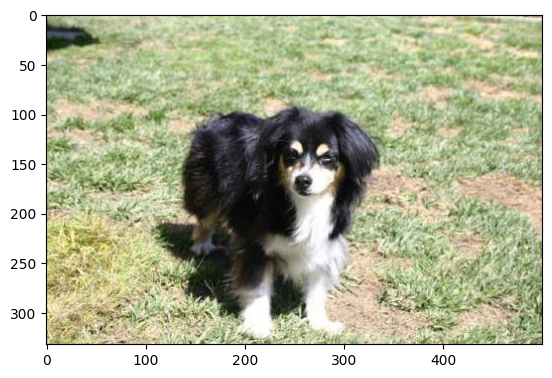

In [15]:
# Draw a cat
# Don't forget to install 'pillow' module (conda install pillow) to give a 'pyplot' ability of working with '.jpg'
img = plt.imread(f'{train_images_path}/{imagenames[1]}')
plt.imshow(img);

Split data on train and validation subsets

In [16]:
# Split data on train and validation subsets
# Using 10% or 20% from train data is classical approach
X_train, X_val = train_test_split(animals, test_size=0.2,  random_state=2)
X_train = X_train.reset_index()
X_val = X_val.reset_index()

# We may want use only 1800 images because of CPU computational reasons. If so, this code should be run
# X_train = X_train.sample(n=1800).reset_index()
# X_val = X_val.sample(n=100).reset_index()

In [17]:
# Count
total_X_train = X_train.shape[0]
total_X_val = X_val.shape[0]

print(total_X_train)
print(total_X_val) 

65
17


CNN Learning

Model 1. VGG16

In [ ]:
# ============ MODEL TRAINING CONFIGURATION ============
import tensorflow as tf

# Detect GPU memory to adjust batch size automatically
gpus = tf.config.list_physical_devices('GPU')
has_gpu = len(gpus) > 0

# Training hyperparameters optimized for CUDA
epochs = 10  # Increased from 5 for better training
batch_size = 16 if has_gpu else 4  # Larger batch for GPU, smaller for CPU

# Image size - use 192 instead of 224 to reduce memory (slight accuracy trade-off)
# Can also use 224 if you have enough VRAM (6GB+)
image_size = 192  # Memory-efficient size (was 224)

print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
print(f"GPU Available: {has_gpu}")
print(f"Batch Size: {batch_size}")
print(f"Image Size: {image_size}x{image_size}")
print(f"Epochs: {epochs}")
print(f"Device Mode: {'GPU' if has_gpu else 'CPU'}")


In [19]:
# VGG16 expects 224x224, but we use 192x192 for memory efficiency
# VGG16 can accept different input sizes, so 192x192 will still work well
# If you want to match the standard 224x224, change back and ensure you have enough VRAM

input_shape = (image_size, image_size, 3)

print(f"Model Input Shape: {input_shape}")
print(f"Note: Using {image_size}x{image_size} instead of standard 224x224 for memory efficiency")


NameError: name 'image_size' is not defined

In [ ]:
# ============ DATA PIPELINE OPTIMIZATION ============
# Enable AutoSharding for distributed data loading
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

# Prefetch configuration optimized for GPU training
AUTO = tf.data.AUTOTUNE
PREFETCH_BUFFER = 2  # Increase for more parallelism, decrease if OOM

print("=" * 60)
print("DATA PIPELINE OPTIMIZATION")
print("=" * 60)
print(f"Prefetch Strategy: AUTOTUNE with buffer size {PREFETCH_BUFFER}")
print(f"This will parallelize data loading with model training")


In [ ]:
# Define our pre-trained model
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

In [ ]:
# Print models summary table
# Note that it expects input pictures in 224 size and 3 channels, as we mensioned before. So we didn't lie.
print(pre_trained_model.summary())

In [ ]:
# Add some micro-tuning 
# Set above layers to be not traianble since using pre-trained model - they are already trained
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

# Specify networks output    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to one dimension
x = GlobalMaxPooling2D()(last_output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Form our model
model_mod = Model(pre_trained_model.input, x)

In [ ]:
# Compile model with optimizations for GPU training
# Use a higher learning rate with mixed precision training
model_mod.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9),  # Higher LR works well with mixed precision
    metrics=['accuracy']
)

print("Model Compiled Successfully")
print(f"Optimizer: SGD with learning_rate=1e-3, momentum=0.9")
print(f"Loss: binary_crossentropy")
print(f"Mixed Precision: Enabled (float16 for faster computation)")


Training DataGenerator

In [ ]:
# Implement train ImageDataGenerator and specify some small preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [ ]:
# Upload images from file system using flow_from_dataframe() with built-in buffering
train_generator = train_datagen.flow_from_dataframe(
    X_train, 
    train_images_path,
    x_col='Image name',
    y_col='Category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size,
)

print(f"Train Generator Created: {X_train.shape[0]} images")
print(f"Samples per batch: {batch_size}")
print("Note: flow_from_dataframe() has built-in buffering for GPU optimization")


Validation DataGenerator

In [ ]:
# Implement validation ImageDataGenerator
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
# Upload and preprocess validation images with optimization
validation_generator = validation_datagen.flow_from_dataframe(
    X_val, 
    train_images_path,
    x_col='Image name',
    y_col='Category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size,
)

print(f"Validation Generator Created: {X_val.shape[0]} images")
print(f"Samples per batch: {batch_size}")
print("Note: flow_from_dataframe() has built-in buffering for GPU optimization")


In [ ]:
# Check one sample generated image
# Create generator for test sample image
generated_example_df = X_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    generated_example_df, 
    train_images_path, 
    x_col='Image name',
    y_col='Category',
    class_mode='categorical',
    #validate_filenames = False
)

In [ ]:
# Plot sample
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Early Stop¶

In [ ]:
# Early Stopping Callback - prevents overfitting and saves training time
earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Increased patience for stable training
    verbose=1, 
    mode='auto',
    restore_best_weights=True
)

print("Early Stopping Callback Configured")
print("- Monitor: val_accuracy")
print("- Patience: 5 epochs")
print("- Restores best weights automatically")


In [ ]:
# Learning Rate Reduction - dynamically reduces LR when validation accuracy plateaus
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5,  # Multiply LR by 0.5 each time
    min_lr=0.00001
)

print("Learning Rate Reduction Callback Configured")
print("- Monitor: val_accuracy")
print("- Patience: 2 epochs")
print("- Reduction factor: 0.5")
print("- Minimum LR: 0.00001")


In [ ]:
# TensorBoard logging callback - for monitoring training on GPU
from tensorflow.keras.callbacks import TensorBoard
import time

log_dir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

print(f"TensorBoard Logging Enabled")
print(f"Logs directory: {log_dir}")
print("Run 'tensorboard --logdir=./logs/fit' to view training metrics")


In [ ]:
# Combine all callbacks for optimal training with GPU utilization
callbacks = [earlystop, learning_rate_reduction, tensorboard]

print("=" * 60)
print("TRAINING CALLBACKS CONFIGURED")
print("=" * 60)
print(f"Total Callbacks: {len(callbacks)}")
for i, cb in enumerate(callbacks, 1):
    print(f"  {i}. {cb.__class__.__name__}")


In [ ]:
callbacks

Model fit

In [ ]:
# Train the model with GPU optimization
import gc

print("=" * 60)
print("STARTING MODEL TRAINING")
print("=" * 60)
print(f"Total Training Samples: {total_X_train}")
print(f"Total Validation Samples: {total_X_val}")
print(f"Batch Size: {batch_size}")
print(f"Steps per Epoch: {total_X_train // batch_size}")
print(f"Device: GPU" if has_gpu else "CPU")
print("=" * 60)

# Clear GPU memory before training
if has_gpu:
    gc.collect()
    tf.keras.backend.clear_session()

# Fit model with GPU optimization
with tf.device('/GPU:0' if has_gpu else '/CPU:0'):
    history = model_mod.fit(
        train_generator,
        steps_per_epoch=total_X_train // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=total_X_val // batch_size,
        callbacks=callbacks,
        verbose=1
    )

print("\n✓ Training Completed Successfully!")


Save the modelm

In [ ]:
# Save calculated weigthts (approx. 60 Mb)
model_mod.save_weights('model_wieghts.h5')
model_mod.save('model_keras.h5')

Visualize model accuracy and loss

In [ ]:
# Plot accuracy and loss curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.plot(history.history['loss'], color='r', label="Train loss")
ax1.plot(history.history['val_loss'], color='b', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
legend = ax1.legend(loc='best', shadow=True)



ax2.plot(history.history['accuracy'], color='r', label="Train accuracy")
ax2.plot(history.history['val_accuracy'], color='b',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
legend = ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

Predict on validation data

In [ ]:
# Prepare Y_val
Y_val = X_val['Category']
# Predict on validation data
Y_pred =  model_mod.predict_generator(validation_generator)

In [ ]:
# Define treshold
threshold = 0.5
# Convert
Y_pred_conv = np.where(Y_pred > threshold, 1,0)

In [ ]:
Y_pred_conv[:,0]

Visualize prediction on validation data

In [ ]:
# Plot probability histogram
pd.Series(Y_pred_conv[:,0]).hist()

In [ ]:
# Compute and plot the Confusion matrix
confusion_mtx = confusion_matrix(Y_val_str, Y_pred_conv) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True)
plt.xlabel("Predicted Label")
plt.ylabel("Validation (aka True) Label")
plt.title("Confusion Matrix")
plt.show()